<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Get-the-matrices" data-toc-modified-id="Get-the-matrices-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get the matrices</a></span></li><li><span><a href="#Viz-costs" data-toc-modified-id="Viz-costs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Viz costs</a></span></li></ul></li><li><span><a href="#Solve" data-toc-modified-id="Solve-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Solve</a></span><ul class="toc-item"><li><span><a href="#Studying-cases-from-matlab" data-toc-modified-id="Studying-cases-from-matlab-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Studying cases from matlab</a></span><ul class="toc-item"><li><span><a href="#k-=-1" data-toc-modified-id="k-=-1-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>k = 1</a></span></li><li><span><a href="#Solving-the-linear-system" data-toc-modified-id="Solving-the-linear-system-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Solving the linear system</a></span></li><li><span><a href="#k-=-2" data-toc-modified-id="k-=-2-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>k = 2</a></span></li></ul></li></ul></li></ul></div>

In [24]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size = 12)
rc('xtick', labelsize = 12)
rc('ytick', labelsize = 12)
rc('figure', figsize = (8, 4))

In [25]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from amod_ed.contractivity_v3 import viz_costs, _construct_problem
from amod_ed.contractivity_v3 import sample_solutions, run_algorithm
import cvxpy as cp
import networkx as nx

import pandas as pd

from amod_ed.contractivity_v3 import plot_results_run, compute_error_KKT, get_d_values

from amod_ed.contractivity_v3 import get_new_r, get_edge_flow, get_flow_edge_od

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Description

# Load

The characteristics of the graph are loaded from Excel files. 

In [26]:
edges = pd.read_excel('cost_edges_3.xlsx')
inv_edges = pd.read_excel('inv_demand_3.xlsx')

In [27]:
edges['phi']=3

In [28]:
edges['k']=1

In [29]:
edges.loc[1:, 'phi'] = 50

In [30]:
# edges.loc[3, 'phi'] = 140
edges.loc[3, 'phi'] = 500

In [31]:
edges

,origin,destination,phi,k
0,1,2,3,1
1,2,1,50,1
2,1,3,50,1
3,3,1,500,1
4,2,3,50,1
5,3,2,50,1


In [32]:
inv_edges['k'] = .5

In [33]:
inv_edges['shift'] = 15

In [34]:
inv_edges['phi']+=1

In [35]:
inv_edges

,origin,destination,phi,k,shift
0,1,2,2,0.5,15
1,2,1,4,0.5,15
2,3,1,3,0.5,15
3,1,3,5,0.5,15
4,2,3,2,0.5,15
5,3,2,4,0.5,15


## Get the matrices

In [36]:
alpha = 0.15

In [37]:
edges['A'] = edges['phi']/edges['k']/2 * alpha

In [38]:
edges

,origin,destination,phi,k,A
0,1,2,3,1,0.225
1,2,1,50,1,3.750
2,1,3,50,1,3.750
3,3,1,500,1,37.500
4,2,3,50,1,3.750
5,3,2,50,1,3.750


In [39]:
#order of edges in matlab
#edges = [1,2;1,3;2,1;2,3;3,1;3,2];
new_order = [0, 2, 1, 4, 3, 5]
edges.loc[new_order, 'A']

0     0.225
2     3.750
1     3.750
4     3.750
3    37.500
5     3.750
Name: A, dtype: float64

In [40]:
edges.loc[new_order, 'phi']

0      3
2     50
1     50
4     50
3    500
5     50
Name: phi, dtype: int64

In [41]:
inv_edges['D'] = inv_edges['phi']/inv_edges['k']/2 * alpha

In [42]:
inv_edges.loc[new_order, 'D']

0    0.30
2    0.45
1    0.60
4    0.30
3    0.75
5    0.60
Name: D, dtype: float64

In [43]:
inv_edges.loc[new_order, 'shift'] - inv_edges.loc[new_order, 'phi']

0    13
2    12
1    11
4    13
3    10
5    11
dtype: int64

## Viz costs

Visualize the costs for each OD pair specified in the Excels. 

In [ ]:
# inv_edges['shift'] = inv_edges['shift']+15

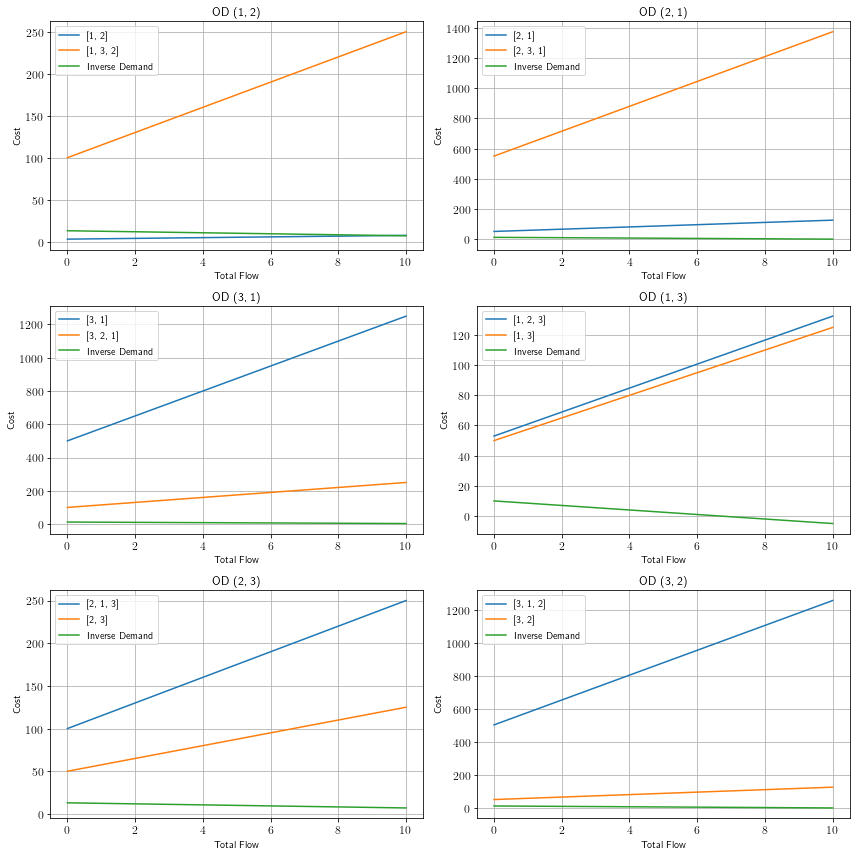

In [13]:
viz_costs(edges, inv_edges, name = 'costs1', save = False, correct = False, beta = 1)

# Solve

In [44]:
correct = False

In [45]:
"""
Returns
-------
f_p: cvxpy.Variable
    The flow for each commodity on each edge
f_r: cvxpy.Variable
    The rebalancing flow on each edge
r: cvxpy.Parameter
    The rebalancing guess for each node
d_var: cvxpy.Variable
    The demand for each each
prob: cvxpy.Problem
    The optimization problem
map_comps: dict
    A map linking components of f_p to the edges and inv edges
map_edges: dict
    A map linking edges to components of f_p
costs_dict: dict
    Dict containing the cost for each edge
inv_demand_dict: dict
    The inverse demand cost for each od pair
G: nx.DiGraph
    Graph representing the network
nodes: list
    list of nodes
"""
f_p, f_r, r, d_var, prob, map_comps, map_edges,\
 costs_dict, inv_d_dict, G, nodes = _construct_problem(edges, inv_edges, correct = correct, beta = 1)

/Users/lucasfuentes/miniconda3/envs/py37/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/lucasfuentes/miniconda3/envs/py37/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/lucasfuen

Specify a value of the rebalancing parameter

In [47]:
x = 9
y = 4

In [48]:
r_new = [x, -x-y, y]
r.value = r_new

You can then solve the problem. 

In [49]:
prob.solve(solver = cp.GUROBI)

Academic license - for non-commercial use only


288.36666691974506

Check the status. 

In [50]:
prob.status

'optimal'

Therefore, the below function helps in analyzing and decomposing edge by edge for the passenger flow. 

In [51]:
get_edge_flow(f_p, map_edges)

{(1, 2): 5.6666666592606,
 (1, 3): 9.694971564284332e-10,
 (2, 1): 1.3563896282944151e-09,
 (2, 3): 1.3953113249251044e-09,
 (3, 1): 4.0455896172073256e-11,
 (3, 2): 4.1531349511600117e-10}

In [52]:
get_d_values(inv_edges, d_var)

{(1, 2): 5.6666666587415175,
 (2, 1): 4.969212761675609e-10,
 (3, 1): 8.642192860088015e-11,
 (1, 3): 5.819988552387552e-10,
 (2, 3): 6.356890521612583e-10,
 (3, 2): 1.262537114482264e-10}

In [53]:
edges

,origin,destination,phi,k,A
0,1,2,3,1,0.225
1,2,1,50,1,3.750
2,1,3,50,1,3.750
3,3,1,500,1,37.500
4,2,3,50,1,3.750
5,3,2,50,1,3.750


In [54]:
f_r.value

array([9.00000000e+00, 1.66579591e-10, 5.38355590e-11, 1.43057618e-11,
       6.15584619e-11, 4.00000000e+00])

In [55]:
kkt_rel_error = compute_error_KKT(G, costs_dict, inv_d_dict, inv_edges, map_comps, f_p)

In [56]:
kkt_rel_error

{(1, 2): [0.9999999991634744, nan],
 (2, 1): [nan, nan],
 (3, 1): [nan, nan],
 (1, 3): [nan, nan],
 (2, 3): [nan, nan],
 (3, 2): [nan, nan]}

We can also compute directly the new rebalancing guess. 

In [57]:
get_new_r(f_p, map_edges, nodes)

[-5.666666658833252, 5.666666656924213, 1.9090390900654632e-09]

## Studying cases from matlab

### k = 1

scen = [2, 1 , 1, 1, 1, 1];
scen_r = [0, 1, 1, 1, 1, 0];

In [59]:
y = 4 #fixed to arbitrary value, as it does not impact the new r at all
r_list = []
Tr_list = []
for x in np.linspace(1, 10, 10):
    r_new = [x, -x-y, y]
    r_list.append(r_new)
    r.value = r_new

    prob.solve(solver = cp.GUROBI)

    get_edge_flow(f_p, map_edges)

    get_d_values(inv_edges, d_var)

    Tr_list.append(get_new_r(f_p, map_edges, nodes))

In [63]:
rat_=[]
for i in range(len(r_list)):
    for j in range(i+1, len(r_list)):
        r1 = np.array(r_list[i])
        r2 = np.array(r_list[j])
        Tr1 = np.array(Tr_list[i])
        Tr2 = np.array(Tr_list[j])
        
        rat = np.linalg.norm(Tr1 - Tr2)/np.linalg.norm(r1-r2)
        rat_.append(rat)

### Solving the linear system

In [75]:
y_vec = [4, 5, 2] #fixed to arbitrary value, as it does not impact the new r at all
r_list = []
Tr_list = []
x_vec = [3,4,5]
for i in range(3):
    x = x_vec[i]
    y = y_vec[i]
    r_new = [x, -x-y, y]
    r_list.append(r_new)
    r.value = r_new

    prob.solve(solver = cp.GUROBI)

    get_edge_flow(f_p, map_edges)

    get_d_values(inv_edges, d_var)

    Tr_list.append(get_new_r(f_p, map_edges, nodes))

In [97]:
b = np.zeros(4)
A = np.zeros((4,4))
for i in [0, 1]:
    dTr = np.array(Tr_list[i]) - np.array(Tr_list[i+1])
    dr = np.array(r_list[i]) - np.array(r_list[i+1])
    s = i*2
    drA = dr[:2]
    A[s, :2] = drA
    A[s+1, 2:] = drA
    b[s:s+2] = dTr[:2]

In [99]:
sol = np.linalg.solve(A, b)

In [100]:
A_sol = [[sol[0], sol[1]], [sol[2], sol[3]]]

In [101]:
A_sol

[[0.4285714274382726, 3.9070990887069e-10],
 [-0.4285714274363248, -3.9047676203551873e-10]]

In [103]:
np.around(A_sol, 4)


array([[ 0.4286,  0.    ],
       [-0.4286, -0.    ]])

### k = 2 

In this case, it is basically the problem that the contractivity ratio is always the same!